Well, this is my personal view for predicting the Sale Price of a houses in Iowa.
As this being my very first machine learning problem (and also Competition), I'm really excited of how this turned out.

As I learn along, maybe in the future I'll be able to bring this kernel to absolute perrrfection. ^^

In [1]:
#Imputs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

**Data Setup**

In [2]:
#Read the data
X = pd.read_csv('../input/iowa-house-prices/train.csv', index_col = 'Id')
X_test = pd.read_csv('../input/iowa-house-prices/test.csv', index_col ='Id')

#Filter from target column null values
X.dropna(axis = 0, subset = ['SalePrice'], inplace = True)
y = X['SalePrice']

#Filter out the target column from X dataset
X.drop(axis = 1, labels = ['SalePrice'], inplace = True)

**Check for Leakage**

In [3]:
#Verify if there are the same number of columns in both test and train data
print(X.shape)
print((X.columns == X_test.columns).sum())

(1460, 79)
79


In [4]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
# MoSold, YrSOld, SaleType, SaleCondition won't be available for a prediction for the new house
#so these columns will be dropped
leakage_columns = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition']
X.drop(labels = leakage_columns, axis = 1, inplace = True)
X_test.drop(labels = leakage_columns, axis = 1, inplace= True)

**Data Preparation: Numerical Data**

In [6]:
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

cols_with_nulls = X[numerical_cols].isnull().sum()
print(cols_with_nulls[cols_with_nulls > 0])

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [7]:
sns.set_style('whitegrid')
df = X[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].dropna(axis = 0)

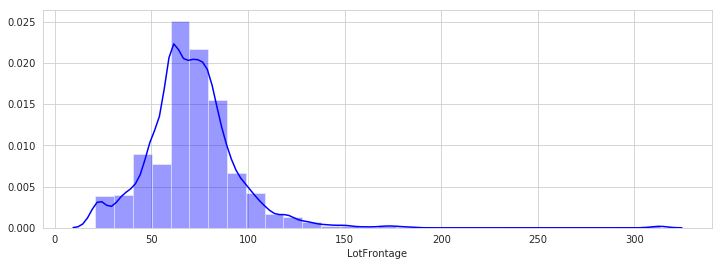

In [8]:
#we'll impute the mode, as the distributions is asymetric and the mean is influenced by outliers
plt.figure(figsize = (12,4))
sns.distplot(a = df['LotFrontage'], bins = 30, norm_hist=False, kde=True, color = 'blue')

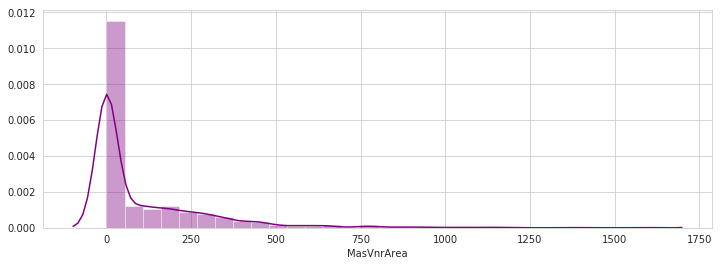

In [9]:
#we'll use most frequent, as the distribution is strongly asymetric to the right
plt.figure(figsize = (12,4))
sns.distplot(a = df['MasVnrArea'], bins = 30, norm_hist=False, kde=True, color = 'purple')

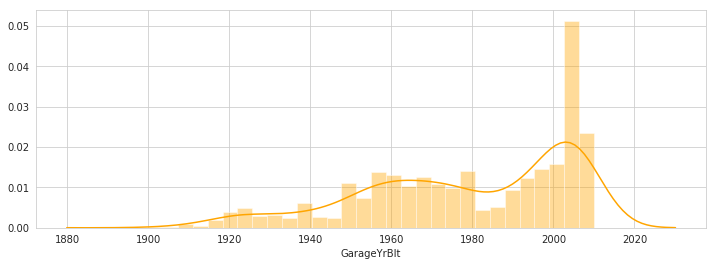

In [10]:
#for this distribution mean should work just fine :)
plt.figure(figsize = (12,4))
sns.distplot(a = df['GarageYrBlt'], bins = 30, norm_hist=False, kde=True, color = 'orange')

In [11]:
#There are only 3 columns with missing values, and they are small in number, so we'll apply Simple Imputation
from sklearn.impute import SimpleImputer

numerical_cols_median = ['LotFrontage']
numerical_transformer_median = SimpleImputer(strategy = 'median')

numerical_cols_mod = ['MasVnrArea']
numerical_transformer_mod = SimpleImputer(strategy = 'most_frequent')

numerical_cols_mean = ['GarageYrBlt']
numerical_transformer_mean = SimpleImputer(strategy = 'mean')

numerical_cols_remain = set(numerical_cols) - set(numerical_cols_mean) - set(numerical_cols_median) - set(numerical_cols_mod)
numerical_cols_remain = list(numerical_cols_remain)

Data Preparation: Categorical Data

In [12]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
cols_with_nulls_categs = X[categorical_cols].isnull().sum()
cols_with_nulls_categs[cols_with_nulls_categs > 0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [13]:
#Because there are a few columns with too many missing values, we'll filter them out from the data
X.drop(labels = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1, inplace = True)
X_test.drop(labels = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1, inplace = True)

In [14]:
#Redo categorical_cols
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
X.shape

(1460, 70)

In [15]:
from sklearn.preprocessing import OneHotEncoder

categ_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'most_frequent')),
                                         ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

Bundle Preprocessing

In [16]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num_median', numerical_transformer_median, numerical_cols_median),
                                               ('num_mod', numerical_transformer_mod, numerical_cols_mod),
                                               ('num_mean', numerical_transformer_mean, numerical_cols_mean),
                                               ('num_rest', numerical_transformer_mean, numerical_cols_remain),
                                              ('cat', categ_transformer, categorical_cols)])

Data Validation

In [17]:
#split the training data into train & valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 0)

Model 1: XGBoost

In [18]:
from xgboost import XGBRegressor
xgboost_1 = XGBRegressor(learning_rate = 0.05, n_estimators=1000, random_state=0)
pipeline_1 = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', xgboost_1)])
pipeline_1.fit(X_train, y_train)
preds_1 = pipeline_1.predict(X_valid)
mae = mean_absolute_error(y_valid, preds_1)
print('MAE 1:', mae)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:08:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE 1: 16539.48269834475


XGBoost (with GridSearch), finding the best params[](http://)

In [19]:
X_train_prep = preprocessor.fit_transform(X_train)

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate' : [0.1, 0.08, 0.05, 0.03, 0.01], 'n_estimators' : [50, 100, 200, 500, 700, 1000]}
grid = GridSearchCV(XGBRegressor(), param_grid, cv = 5, verbose=5)

grid.fit(X_train_prep, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] learning_rate=0.1, n_estimators=50 ..............................
[16:08:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .. learning_rate=0.1, n_estimators=50, score=0.729, total=   0.2s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[16:08:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] .. learning_rate=0.1, n_estimators=50, score=0.888, total=   0.2s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[16:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .. learning_rate=0.1, n_estimators=50, score=0.854, total=   0.2s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[16:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] .. learning_rate=0.1, n_estimators=50, score=0.864, total=   0.2s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[16:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .. learning_rate=0.1, n_estimators=50, score=0.905, total=   0.2s
[CV] learning_rate=0.1, n_estimators=100 .............................
[16:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=100, score=0.730, total=   0.3s
[CV] learning_rate=0.1, n_estimators=100 .............................
[16:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=100, score=0.892, total=   0.3s
[CV] learning_rate=0.1, n_estimators=100 .............................
[16:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=100, score=0.870, total=   0.3s
[CV] learning_rate=0.1, n_estimators=100 .............................
[16:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=100, score=0.876, total=   0.3s
[CV] learning_rate=0.1, n_estimators=100 .............................
[16:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=100, score=0.906, total=   0.3s
[CV] learning_rate=0.1, n_estimators=200 .............................
[16:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=200, score=0.724, total=   0.6s
[CV] learning_rate=0.1, n_estimators=200 .............................
[16:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=200, score=0.892, total=   0.6s
[CV] learning_rate=0.1, n_estimators=200 .............................
[16:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=200, score=0.875, total=   0.6s
[CV] learning_rate=0.1, n_estimators=200 .............................
[16:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=200, score=0.881, total=   0.6s
[CV] learning_rate=0.1, n_estimators=200 .............................
[16:09:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=200, score=0.907, total=   0.6s
[CV] learning_rate=0.1, n_estimators=500 .............................
[16:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=500, score=0.718, total=   1.4s
[CV] learning_rate=0.1, n_estimators=500 .............................
[16:09:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=500, score=0.891, total=   1.4s
[CV] learning_rate=0.1, n_estimators=500 .............................
[16:09:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=500, score=0.877, total=   1.4s
[CV] learning_rate=0.1, n_estimators=500 .............................
[16:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=500, score=0.887, total=   1.4s
[CV] learning_rate=0.1, n_estimators=500 .............................
[16:09:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=500, score=0.905, total=   1.4s
[CV] learning_rate=0.1, n_estimators=700 .............................
[16:09:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=700, score=0.715, total=   2.0s
[CV] learning_rate=0.1, n_estimators=700 .............................
[16:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=700, score=0.890, total=   2.0s
[CV] learning_rate=0.1, n_estimators=700 .............................
[16:09:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=700, score=0.877, total=   2.0s
[CV] learning_rate=0.1, n_estimators=700 .............................
[16:09:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=700, score=0.889, total=   2.0s
[CV] learning_rate=0.1, n_estimators=700 .............................
[16:09:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.1, n_estimators=700, score=0.907, total=   2.0s
[CV] learning_rate=0.1, n_estimators=1000 ............................
[16:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.1, n_estimators=1000, score=0.715, total=   2.8s
[CV] learning_rate=0.1, n_estimators=1000 ............................
[16:09:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.1, n_estimators=1000, score=0.891, total=   2.8s
[CV] learning_rate=0.1, n_estimators=1000 ............................
[16:09:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.1, n_estimators=1000, score=0.877, total=   2.8s
[CV] learning_rate=0.1, n_estimators=1000 ............................
[16:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.1, n_estimators=1000, score=0.890, total=   2.8s
[CV] learning_rate=0.1, n_estimators=1000 ............................
[16:09:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.1, n_estimators=1000, score=0.908, total=   2.8s
[CV] learning_rate=0.08, n_estimators=50 .............................
[16:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.08, n_estimators=50, score=0.750, total=   0.2s
[CV] learning_rate=0.08, n_estimators=50 .............................
[16:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.08, n_estimators=50, score=0.884, total=   0.2s
[CV] learning_rate=0.08, n_estimators=50 .............................
[16:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.08, n_estimators=50, score=0.846, total=   0.2s
[CV] learning_rate=0.08, n_estimators=50 .............................
[16:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.08, n_estimators=50, score=0.851, total=   0.2s
[CV] learning_rate=0.08, n_estimators=50 .............................
[16:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.08, n_estimators=50, score=0.898, total=   0.2s
[CV] learning_rate=0.08, n_estimators=100 ............................


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.08, n_estimators=100, score=0.742, total=   0.3s
[CV] learning_rate=0.08, n_estimators=100 ............................
[16:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=100, score=0.894, total=   0.3s
[CV] learning_rate=0.08, n_estimators=100 ............................
[16:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=100, score=0.868, total=   0.3s
[CV] learning_rate=0.08, n_estimators=100 ............................
[16:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=100, score=0.867, total=   0.3s
[CV] learning_rate=0.08, n_estimators=100 ............................
[16:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=100, score=0.906, total=   0.3s
[CV] learning_rate=0.08, n_estimators=200 ............................
[16:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=200, score=0.744, total=   0.6s
[CV] learning_rate=0.08, n_estimators=200 ............................
[16:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=200, score=0.889, total=   0.6s
[CV] learning_rate=0.08, n_estimators=200 ............................
[16:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=200, score=0.874, total=   0.6s
[CV] learning_rate=0.08, n_estimators=200 ............................
[16:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=200, score=0.874, total=   0.6s
[CV] learning_rate=0.08, n_estimators=200 ............................
[16:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=200, score=0.909, total=   0.6s
[CV] learning_rate=0.08, n_estimators=500 ............................
[16:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=500, score=0.741, total=   1.4s
[CV] learning_rate=0.08, n_estimators=500 ............................
[16:09:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=500, score=0.888, total=   1.4s
[CV] learning_rate=0.08, n_estimators=500 ............................
[16:09:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=500, score=0.874, total=   1.4s
[CV] learning_rate=0.08, n_estimators=500 ............................
[16:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=500, score=0.880, total=   1.4s
[CV] learning_rate=0.08, n_estimators=500 ............................
[16:09:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=500, score=0.910, total=   1.4s
[CV] learning_rate=0.08, n_estimators=700 ............................
[16:09:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=700, score=0.739, total=   2.0s
[CV] learning_rate=0.08, n_estimators=700 ............................
[16:09:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=700, score=0.887, total=   2.0s
[CV] learning_rate=0.08, n_estimators=700 ............................
[16:09:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=700, score=0.874, total=   2.0s
[CV] learning_rate=0.08, n_estimators=700 ............................
[16:09:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=700, score=0.881, total=   2.0s
[CV] learning_rate=0.08, n_estimators=700 ............................
[16:09:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=700, score=0.911, total=   2.0s
[CV] learning_rate=0.08, n_estimators=1000 ...........................
[16:09:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=1000, score=0.741, total=   2.9s
[CV] learning_rate=0.08, n_estimators=1000 ...........................
[16:10:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=1000, score=0.887, total=   2.9s
[CV] learning_rate=0.08, n_estimators=1000 ...........................
[16:10:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=1000, score=0.873, total=   2.9s
[CV] learning_rate=0.08, n_estimators=1000 ...........................
[16:10:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=1000, score=0.880, total=   2.9s
[CV] learning_rate=0.08, n_estimators=1000 ...........................
[16:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.08, n_estimators=1000, score=0.911, total=   2.8s
[CV] learning_rate=0.05, n_estimators=50 .............................
[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.05, n_estimators=50, score=0.743, total=   0.2s
[CV] learning_rate=0.05, n_estimators=50 .............................
[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.05, n_estimators=50, score=0.816, total=   0.2s
[CV] learning_rate=0.05, n_estimators=50 .............................
[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.05, n_estimators=50, score=0.769, total=   0.2s
[CV] learning_rate=0.05, n_estimators=50 .............................
[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.05, n_estimators=50, score=0.796, total=   0.2s
[CV] learning_rate=0.05, n_estimators=50 .............................
[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.05, n_estimators=50, score=0.829, total=   0.2s
[CV] learning_rate=0.05, n_estimators=100 ............................
[16:10:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=100, score=0.737, total=   0.3s
[CV] learning_rate=0.05, n_estimators=100 ............................
[16:10:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=100, score=0.888, total=   0.3s
[CV] learning_rate=0.05, n_estimators=100 ............................
[16:10:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=100, score=0.859, total=   0.3s
[CV] learning_rate=0.05, n_estimators=100 ............................
[16:10:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=100, score=0.860, total=   0.3s
[CV] learning_rate=0.05, n_estimators=100 ............................
[16:10:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=100, score=0.906, total=   0.3s
[CV] learning_rate=0.05, n_estimators=200 ............................
[16:10:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=200, score=0.738, total=   0.6s
[CV] learning_rate=0.05, n_estimators=200 ............................
[16:10:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=200, score=0.891, total=   0.6s
[CV] learning_rate=0.05, n_estimators=200 ............................
[16:10:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=200, score=0.875, total=   0.6s
[CV] learning_rate=0.05, n_estimators=200 ............................
[16:10:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=200, score=0.871, total=   0.6s
[CV] learning_rate=0.05, n_estimators=200 ............................
[16:10:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=200, score=0.908, total=   0.6s
[CV] learning_rate=0.05, n_estimators=500 ............................
[16:10:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=500, score=0.734, total=   1.4s
[CV] learning_rate=0.05, n_estimators=500 ............................
[16:10:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=500, score=0.891, total=   1.4s
[CV] learning_rate=0.05, n_estimators=500 ............................
[16:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=500, score=0.879, total=   1.4s
[CV] learning_rate=0.05, n_estimators=500 ............................
[16:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=500, score=0.880, total=   1.4s
[CV] learning_rate=0.05, n_estimators=500 ............................
[16:10:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=500, score=0.909, total=   1.4s
[CV] learning_rate=0.05, n_estimators=700 ............................
[16:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=700, score=0.730, total=   2.0s
[CV] learning_rate=0.05, n_estimators=700 ............................
[16:10:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=700, score=0.890, total=   2.0s
[CV] learning_rate=0.05, n_estimators=700 ............................
[16:10:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=700, score=0.880, total=   2.0s
[CV] learning_rate=0.05, n_estimators=700 ............................
[16:10:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=700, score=0.884, total=   2.0s
[CV] learning_rate=0.05, n_estimators=700 ............................
[16:10:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=700, score=0.908, total=   1.9s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[16:10:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=1000, score=0.728, total=   2.8s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[16:10:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=1000, score=0.889, total=   2.8s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[16:10:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=1000, score=0.879, total=   2.8s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[16:10:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=1000, score=0.886, total=   2.8s
[CV] learning_rate=0.05, n_estimators=1000 ...........................
[16:10:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.05, n_estimators=1000, score=0.909, total=   2.8s
[CV] learning_rate=0.03, n_estimators=50 .............................
[16:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.03, n_estimators=50, score=0.510, total=   0.2s
[CV] learning_rate=0.03, n_estimators=50 .............................
[16:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.03, n_estimators=50, score=0.511, total=   0.2s
[CV] learning_rate=0.03, n_estimators=50 .............................
[16:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.03, n_estimators=50, score=0.471, total=   0.2s
[CV] learning_rate=0.03, n_estimators=50 .............................
[16:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] . learning_rate=0.03, n_estimators=50, score=0.471, total=   0.2s
[CV] learning_rate=0.03, n_estimators=50 .............................
[16:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] . learning_rate=0.03, n_estimators=50, score=0.465, total=   0.2s
[CV] learning_rate=0.03, n_estimators=100 ............................
[16:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=100, score=0.754, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[16:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=100, score=0.857, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[16:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=100, score=0.806, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[16:10:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=100, score=0.830, total=   0.3s
[CV] learning_rate=0.03, n_estimators=100 ............................
[16:10:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=100, score=0.870, total=   0.3s
[CV] learning_rate=0.03, n_estimators=200 ............................
[16:10:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=200, score=0.730, total=   0.6s
[CV] learning_rate=0.03, n_estimators=200 ............................
[16:10:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=200, score=0.894, total=   0.6s
[CV] learning_rate=0.03, n_estimators=200 ............................
[16:10:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=200, score=0.864, total=   0.6s
[CV] learning_rate=0.03, n_estimators=200 ............................
[16:10:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=200, score=0.868, total=   0.6s
[CV] learning_rate=0.03, n_estimators=200 ............................
[16:10:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=200, score=0.906, total=   0.6s
[CV] learning_rate=0.03, n_estimators=500 ............................
[16:10:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=500, score=0.739, total=   1.4s
[CV] learning_rate=0.03, n_estimators=500 ............................
[16:10:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=500, score=0.895, total=   1.4s
[CV] learning_rate=0.03, n_estimators=500 ............................
[16:10:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=500, score=0.873, total=   1.4s
[CV] learning_rate=0.03, n_estimators=500 ............................
[16:10:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=500, score=0.880, total=   1.4s
[CV] learning_rate=0.03, n_estimators=500 ............................
[16:10:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=500, score=0.908, total=   1.4s
[CV] learning_rate=0.03, n_estimators=700 ............................
[16:11:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=700, score=0.737, total=   2.0s
[CV] learning_rate=0.03, n_estimators=700 ............................
[16:11:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=700, score=0.894, total=   2.0s
[CV] learning_rate=0.03, n_estimators=700 ............................
[16:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=700, score=0.873, total=   2.0s
[CV] learning_rate=0.03, n_estimators=700 ............................
[16:11:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=700, score=0.882, total=   2.0s
[CV] learning_rate=0.03, n_estimators=700 ............................
[16:11:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=700, score=0.907, total=   2.0s
[CV] learning_rate=0.03, n_estimators=1000 ...........................
[16:11:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=1000, score=0.732, total=   2.8s
[CV] learning_rate=0.03, n_estimators=1000 ...........................
[16:11:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=1000, score=0.893, total=   2.8s
[CV] learning_rate=0.03, n_estimators=1000 ...........................
[16:11:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=1000, score=0.874, total=   2.8s
[CV] learning_rate=0.03, n_estimators=1000 ...........................
[16:11:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=1000, score=0.885, total=   2.8s
[CV] learning_rate=0.03, n_estimators=1000 ...........................
[16:11:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.03, n_estimators=1000, score=0.907, total=   2.8s
[CV] learning_rate=0.01, n_estimators=50 .............................
[16:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, n_estimators=50, score=-1.408, total=   0.2s
[CV] learning_rate=0.01, n_estimators=50 .............................


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, n_estimators=50, score=-1.499, total=   0.2s
[CV] learning_rate=0.01, n_estimators=50 .............................
[16:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=50, score=-1.343, total=   0.2s
[CV] learning_rate=0.01, n_estimators=50 .............................
[16:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, n_estimators=50, score=-1.723, total=   0.2s
[CV] learning_rate=0.01, n_estimators=50 .............................


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, n_estimators=50, score=-1.950, total=   0.2s
[CV] learning_rate=0.01, n_estimators=100 ............................
[16:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, n_estimators=100, score=-0.009, total=   0.3s
[CV] learning_rate=0.01, n_estimators=100 ............................
[16:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=100, score=-0.063, total=   0.3s
[CV] learning_rate=0.01, n_estimators=100 ............................
[16:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=100, score=-0.047, total=   0.3s
[CV] learning_rate=0.01, n_estimators=100 ............................
[16:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=100, score=-0.138, total=   0.3s
[CV] learning_rate=0.01, n_estimators=100 ............................
[16:11:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=100, score=-0.223, total=   0.3s
[CV] learning_rate=0.01, n_estimators=200 ............................
[16:11:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=200, score=0.683, total=   0.6s
[CV] learning_rate=0.01, n_estimators=200 ............................
[16:11:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=200, score=0.718, total=   0.6s
[CV] learning_rate=0.01, n_estimators=200 ............................
[16:11:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=200, score=0.670, total=   0.6s
[CV] learning_rate=0.01, n_estimators=200 ............................
[16:11:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=200, score=0.702, total=   0.6s
[CV] learning_rate=0.01, n_estimators=200 ............................
[16:11:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=200, score=0.714, total=   0.6s
[CV] learning_rate=0.01, n_estimators=500 ............................
[16:11:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=500, score=0.739, total=   1.4s
[CV] learning_rate=0.01, n_estimators=500 ............................
[16:11:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=500, score=0.891, total=   1.4s
[CV] learning_rate=0.01, n_estimators=500 ............................
[16:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=500, score=0.857, total=   1.4s
[CV] learning_rate=0.01, n_estimators=500 ............................
[16:11:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=500, score=0.864, total=   1.4s
[CV] learning_rate=0.01, n_estimators=500 ............................
[16:11:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=500, score=0.904, total=   1.4s
[CV] learning_rate=0.01, n_estimators=700 ............................
[16:11:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=700, score=0.735, total=   2.0s
[CV] learning_rate=0.01, n_estimators=700 ............................
[16:11:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=700, score=0.894, total=   2.0s
[CV] learning_rate=0.01, n_estimators=700 ............................
[16:11:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=700, score=0.867, total=   2.0s
[CV] learning_rate=0.01, n_estimators=700 ............................
[16:11:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=700, score=0.870, total=   2.0s
[CV] learning_rate=0.01, n_estimators=700 ............................
[16:11:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=700, score=0.906, total=   2.0s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[16:11:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=1000, score=0.741, total=   2.8s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[16:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=1000, score=0.894, total=   2.8s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[16:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=1000, score=0.872, total=   2.8s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[16:11:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=1000, score=0.874, total=   2.8s
[CV] learning_rate=0.01, n_estimators=1000 ...........................
[16:11:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  learning_rate=0.01, n_estimators=1000, score=0.907, total=   2.8s
[16:12:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.0min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.08, 0.05, 0.03, 0.01],
                         'n_estimators': [50, 100

In [21]:
print('Best params:', grid.best_params_)
print('Best estim:', grid.best_estimator_)
print('Best score:', grid.best_score_)

Best params: {'learning_rate': 0.03, 'n_estimators': 700}
Best estim: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
Best score: 0.8589153379662594


Model 2: XGBoost with best Params

In [22]:
xgboost_2 = XGBRegressor(learning_rate=0.01, n_estimators= 1000)

pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', xgboost_2)])

pipeline_2.fit(X_train, y_train)

preds_2 = pipeline_2.predict(X_valid)
mae = mean_absolute_error(y_valid, preds_2)
print('MAE 2:', mae)

[16:12:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


MAE 2: 16730.86238049372


Well, this is it.
Loved this project!